In [ ]:
# DATA PREPROCESSING
# Install specific packages
!pip install iterative-stratification

# Import libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import clear_session
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from sklearn.preprocessing import MultiLabelBinarizer
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report, roc_auc_score, fbeta_score
from wordcloud import WordCloud

In [ ]:
# Load the dataset directly from the given URL
url = 'https://proai-datasets.s3.eu-west-3.amazonaws.com/Filter_Toxic_Comments_dataset.csv'
df = pd.read_csv(url)

# Display the first few rows
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


##**DATASET OVERVIEW:**
This dataset originates from the **Jigsaw Toxic Comment Classification Challenge** and is designed to train a **multi-label classifier for detecting various forms of toxic content in user-generated comments**. Each row represents a single comment along with **binary labels** indicating whether that comment exhibits one or more specific types of toxicity.

The dataset contains the following columns:

- **id**: A unique string identifier for each comment. It is useful for reference and tracking but is not used as input for model training.

- **comment_text**: The raw text of the user comment. This is the primary input feature for the model and consists of free-form text that may or may not contain offensive, abusive, or threatening language.

The remaining **six columns** represent the **target labels** for the **classification task**. Each of them contains a **0** (**absent**) or **1** (**present**), indicating whether the specific type of toxicity is present in the comment:

1. **toxic**: The comment contains rude, disrespectful, or unreasonable language that is likely to make people leave a discussion.

2. **severe_toxic**: A more extreme form of toxicity, often including hate speech or graphic threats.

3. **obscene**: The comment includes obscene or vulgar language.

4. **threat**: The comment contains threats of violence or harm toward individuals or groups.

5. **insult**: The comment includes personal insults or name-calling.

6. **identity_hate**: The comment targets a specific group based on race, religion, gender, sexual orientation, or other identity-related attributes.

Since the problem is **multi-label**, each comment may be associated with **none**, **one**, or **several** of these toxicity categories. For example, a comment could be both toxic and insulting but not obscene or threatening. The **goal** of the project is to train a model that can correctly predict these labels for new, unseen comments, helping platforms like TechTalk automate and scale their moderation processes.

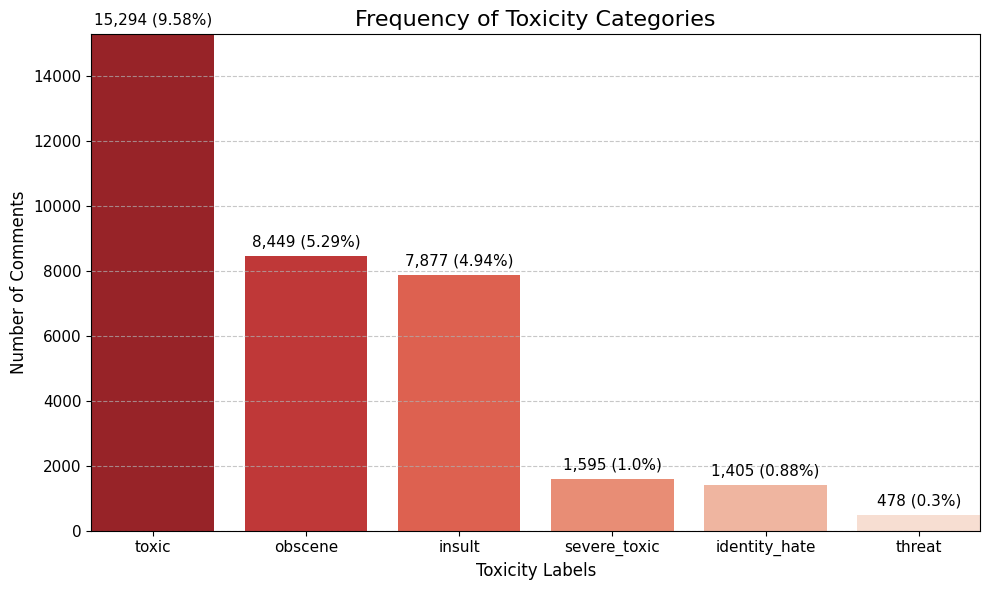

In [ ]:
# Define the label columns to analyze
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Count total occurrences of each label
label_counts = df[label_cols].sum().sort_values(ascending=False).reset_index()
label_counts.columns = ['label', 'count']

# Compute percentages
label_counts['percent'] = (label_counts['count'] / len(df) * 100).round(2)

# Plot the label distribution
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=label_counts,
    x='label',
    y='count',
    hue='label',
    palette='Reds_r',
    legend=False
)

# Add count and percentage labels on top of each bar
for i, bar in enumerate(ax.patches):
    count = int(label_counts.loc[i, 'count'])
    pct = label_counts.loc[i, 'percent']
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 300,  # slight padding
        f"{count:,} ({pct}%)",
        ha='center',
        fontsize=11
    )

# Title and axis labels
plt.title("Frequency of Toxicity Categories", fontsize=16)
plt.ylabel("Number of Comments", fontsize=12)
plt.xlabel("Toxicity Labels", fontsize=12)

# Tick styling
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Add gridlines on y-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Remove extra margins
plt.margins(0)

# Apply tight layout
plt.tight_layout()
plt.show()

This section performs an **exploratory analysis of the dataset's toxicity labels**. It begins by identifying the **six target categories**:

- **toxic**
- **severe_toxic**
- **obscene**
- **threat**
- **insult**
- **identity_hate**

For each of these labels, it calculates the **total number of comments in which the label is present**. Additionally, it computes the **percentage that each label represents relative to the total number of comments** in the dataset.

To help visualize the distribution, a **bar chart** is generated where each bar corresponds to a specific label. Both the **absolute count and the percentage** are displayed directly **above** each bar, making it easier to interpret the **prevalence** of each class at a glance.

This visualization is especially valuable for identifying **severe class imbalance** — for example, the **toxic label** is present in approximately **9.58% of all comments**, while **threat** appears in less than **0.3%**. Understanding this imbalance is crucial when designing **classification models** and deciding on techniques such as focal loss, threshold tuning, or data resampling to improve performance on minority classes.

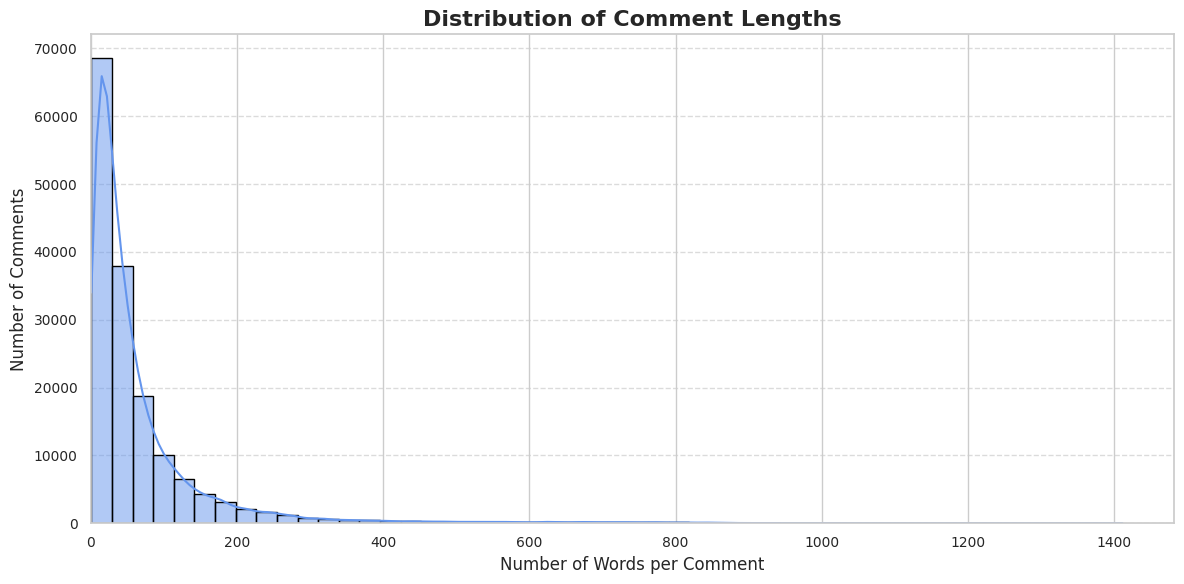

In [ ]:
# Calculate number of words per comment
df['comment_length'] = df['comment_text'].apply(lambda x: len(str(x).split()))

# Set the visual style
sns.set(style='whitegrid')

# Create the histogram
plt.figure(figsize=(12, 6))
sns.histplot(
    df['comment_length'],
    bins=50,
    kde=True,
    color='cornflowerblue',
    edgecolor='black'
)

# Title and axis labels
plt.title("Distribution of Comment Lengths", fontsize=16, weight='bold')
plt.xlabel("Number of Words per Comment", fontsize=12)
plt.ylabel("Number of Comments", fontsize=12)

# Force axes to start at 0
plt.xlim(left=0)
plt.ylim(bottom=0)

# Remove extra margins
plt.margins(0)

# Tick styling
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Remove extra margins
plt.margins(0)

# Optimize spacing
plt.tight_layout()

# Show the plot
plt.show()

This code calculates the **number of words** in each comment and visualizes the **distribution** using a histogram with 50 bins and a KDE curve. It shows **how long comments** typically are, helping to understand the **dataset's structure** and informing **preprocessing decisions** (e.g., sequence length for models).

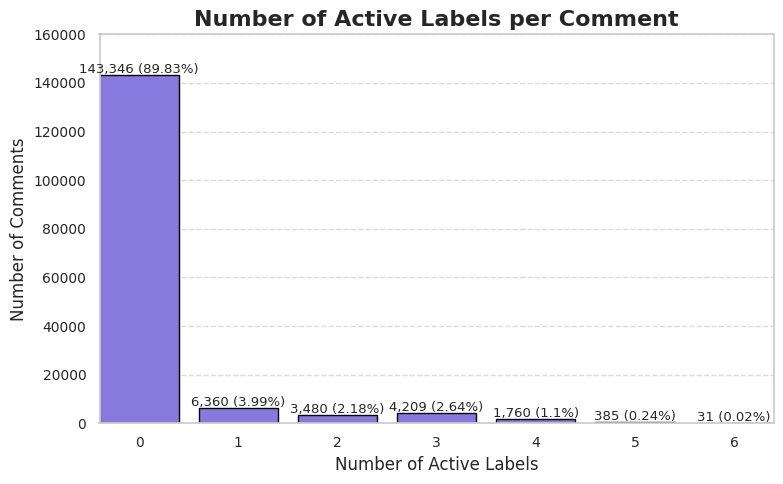

In [ ]:
# Count how many labels are active per comment
df['num_labels'] = df[label_cols].sum(axis=1)

# Set visual style
sns.set(style='whitegrid')

# Plot distribution of active labels per comment
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='num_labels', data=df, color='mediumslateblue', edgecolor='black')

# Calculate counts and percentages for each bar
counts = df['num_labels'].value_counts().sort_index()
total = len(df)
percentages = (counts / total * 100).round(2)

# Add count and percentage labels on top of each bar
for i, count in enumerate(counts):
    ax.text(
        i,  # x position: the category index (0,1,2,...)
        count + total*0.005,  # y position: slightly above the bar
        f"{count:,} ({percentages[i]}%)",
        ha='center',
        fontsize=9.5
    )

# Title and axis labels
plt.title("Number of Active Labels per Comment", fontsize=16, weight='bold')
plt.xlabel("Number of Active Labels", fontsize=12)
plt.ylabel("Number of Comments", fontsize=12)

# Tick styling
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add gridlines on y-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Remove extra margins
plt.margins(0)

# Set y-axis limits
plt.ylim(0, 160000)

# Tight layout for neat spacing
plt.tight_layout()

# Show the plot
plt.show()

This code calculates the number of **active toxicity labels** for each comment by summing the label columns row-wise. It then visualizes the **distribution of these counts** using a count plot with a clean and readable style. This visualization reveals how many comments have **no labels**, a **single label**, or **multiple simultaneous labels**, providing insight into the complexity and overlap of toxic behaviors in the dataset.

In this plot, the **x-axis** represents the number of active toxicity labels present simultaneously in each comment. For example:
- 0 means the comment has **no toxic labels** (it is clean)
- 1 means exactly **one toxicity category is active** (like only "toxic" or only "insult")
- 2 means **two labels are active together**, and so on.

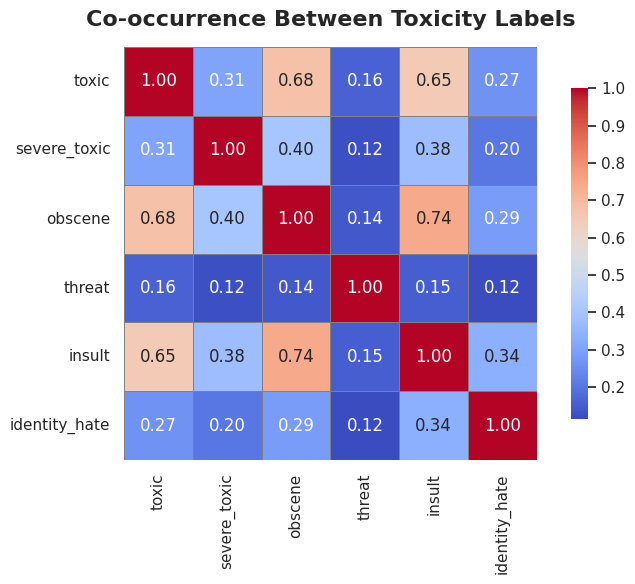

In [ ]:
# Create a correlation matrix between label columns
co_occurrence = df[label_cols].corr()

# Set visual style
sns.set(style='white')

# Plot heatmap of label correlations
plt.figure(figsize=(8, 6))
sns.heatmap(
    co_occurrence,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={"shrink": 0.8},
    square=True,
    annot_kws={"size": 12}
)

# Title with styling
plt.title("Co-occurrence Between Toxicity Labels", fontsize=16, weight='bold', pad=15)

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()

This heatmap shows the **correlation** between **different toxicity labels** within the dataset. Each cell represents the **Pearson correlation coefficient** between a pair of labels, ranging from **-1 (perfect negative correlation) to 1 (perfect positive correlation)**. **Higher values** indicate that **two toxicity categories often co-occur in the same comment**. For example, a strong positive correlation between "toxic" and "insult" suggests that comments labeled as "toxic" are also frequently labeled as "insulting".

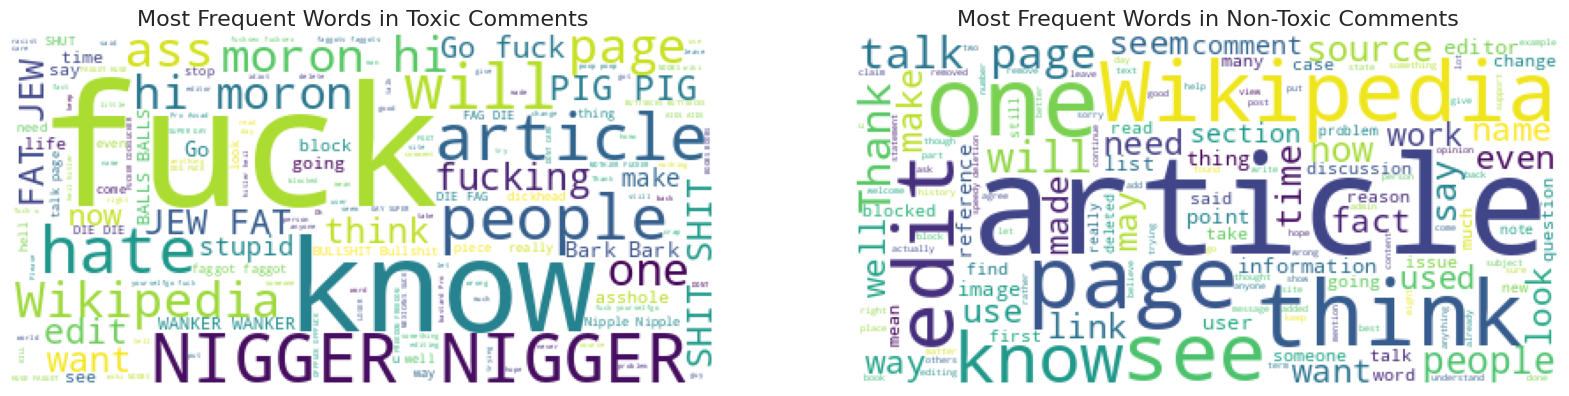

In [ ]:
# Toxic vs non-toxic comments
toxic_text = " ".join(df[df['toxic']==1]['comment_text'])
non_toxic_text = " ".join(df[df[label_cols].sum(axis=1)==0]['comment_text'])

# Generate word clouds
fig, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].imshow(WordCloud(max_words=200, background_color='white').generate(toxic_text))
ax[0].set_title("Most Frequent Words in Toxic Comments", fontsize=16)
ax[0].axis('off')

ax[1].imshow(WordCloud(max_words=200, background_color='white').generate(non_toxic_text))
ax[1].set_title("Most Frequent Words in Non-Toxic Comments", fontsize=16)
ax[1].axis('off')
plt.show()

This visualization uses **two word clouds** to compare **the most frequently used words in toxic versus non-toxic comments**. The **first cloud** displays the most common terms in comments labeled as **"toxic"**, while the **second** shows those found in clean, non-toxic comments (i.e., those with **no toxicity labels** at all). Word clouds visually emphasize words based on **frequency** — the larger and bolder a word appears, the more often it occurs in the text. This comparison helps reveal **linguistic patterns** or **vocabulary differences** between the two groups, potentially highlighting aggressive, offensive, or inflammatory language in toxic content versus more neutral or conversational tone in non-toxic comments.

In [ ]:
# MANAGEMENT OF CLASS IMBALANCE
# Oversample each rare class with different weights
df_severe = df[df['severe_toxic'] == 1]
df_threat = df[df['threat'] == 1]
df_identity = df[df['identity_hate'] == 1]

# Perform targeted oversampling:
# 'threat' is extremely rare, 'identity_hate' is moderately rare
df_oversampled = pd.concat([
    df,
    df_severe.sample(frac=3, replace=True, random_state=42),
    df_threat.sample(frac=10, replace=True, random_state=42),
    df_identity.sample(frac=5, replace=True, random_state=42)
], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)

This code block addresses the issue of **class imbalance**, which is especially critical in **multi-label classification tasks** where some categories are highly underrepresented. In this dataset, the **minority classes** — **'severe_toxic'**, **'threat'**, and **'identity_hate'** — appear much less frequently compared to dominant classes like 'toxic' or 'obscene'.

To counteract this, the method performs targeted oversampling:

- **'severe_toxic'** samples are tripled (frac=3);

- **'identity_hate'** samples are quintupled (frac=5);

- **'threat'**, the rarest class, is replicated tenfold (frac=10)

Each of these subsets is sampled **with replacement**, then concatenated back to the original dataset. The resulting dataset is finally **shuffled** to eliminate ordering bias and ensure a uniform distribution during training.

This oversampling strategy boosts the model’s exposure to these **critical minority classes**, improving its ability to detect **rare but harmful behaviors**, which are often the most important in content moderation systems. Without this rebalancing, the model would likely default to predicting **only majority labels**, severely reducing recall on minority categories — a major risk in real-world toxic comment detection.

In [ ]:
# Tokenization and sequence padding
MAX_NUM_WORDS = 20000
MAX_SEQUENCE_LENGTH = 200

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, lower=True)
tokenizer.fit_on_texts(df_oversampled['comment_text'].astype(str))
sequences = tokenizer.texts_to_sequences(df_oversampled['comment_text'].astype(str))
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

This code block performs **tokenization and padding**, a key part of preprocessing in natural language processing pipelines for neural networks.

- **Tokenizer** builds a vocabulary from the most frequent **20,000 words** in the dataset and assigns a unique integer index to each word.

- All text comments are converted into **sequences of integers** using this vocabulary.

- The sequences are then **padded or truncated** to a fixed length of 200 tokens, ensuring uniform input shape for the recurrent layers (such as LSTMs or GRUs).

These steps are **crucial for feeding the data into a deep learning model**, allowing the network to process sequences of words as fixed-size numeric vectors. Limiting the vocabulary size and padding the sequences also helps improve **training efficiency and generalization**.

Although this baseline approach is effective, it can be further enhanced by incorporating **pre-trained embeddings** (like *GloVe*, *FastText*) or **contextual representations** (like *BERT*) in more advanced setups.

In [ ]:
# Label extraction
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y = df_oversampled[label_cols].values

This code block performs **label extraction** by selecting the **six target categories** (*label_cols*) from the oversampled dataset, which represent the **presence** (*1*) or **absence** (*0*) of each type of toxic behavior.

By converting these columns into a **NumPy array** (*y*), the labels are formatted into a structure suitable for **multi-label classification**, where each comment can simultaneously belong to multiple classes (e.g., *toxic* and *insulting*).

This step is essential for supervised learning, as it provides the **ground truth** that the model uses to learn how to map input comments to their corresponding **toxicity categories**. Proper label formatting ensures that the deep learning model can calculate loss and update its parameters during training.

In [ ]:
# Train/val/test stratified multilabel split
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, temp_idx = next(msss.split(X, y))
X_train, y_train = X[train_idx], y[train_idx]
X_temp, y_temp = X[temp_idx], y[temp_idx]

msss_val_test = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx, test_idx = next(msss_val_test.split(X_temp, y_temp))
X_val, y_val = X_temp[val_idx], y_temp[val_idx]
X_test, y_test = X_temp[test_idx], y_temp[test_idx]

This step performs a **multilabel-stratified split** of the dataset into three subsets: **training**, **validation**, and **test**. Instead of a regular random split, it uses **MultilabelStratifiedShuffleSplit**, which ensures that the **distribution of each toxicity label is preserved** across all subsets—this is especially important in multi-label tasks with class imbalance.

- The **first split** reserves *20%* of the data for **temporary use**, keeping *80%* for **training**;

- The temporary *20%* is then evenly divided into **validation** and **test** sets (*10%* each of the **total data**), again using stratified splitting

Such careful data partitioning is **crucial** for:

- **Training** the model (X_train, y_train);

- **Tuning** and **early stopping** (X_val, y_val);

- **Final unbiased evaluation** (X_test, y_test)

Using *random_state=42* ensures that results are **reproducible**, supporting reliable experimentation and comparison.

In [ ]:
# Calculate inverse class weights (to balance rare classes)
class_counts = y_train.sum(axis=0)  # Count of positive samples per class in training set
total_samples = y_train.shape[0]    # Total number of training samples
class_weights = total_samples / (len(label_cols) * class_counts)  # Inverse frequency weighting
class_weights = np.clip(class_weights, 1.0, None)  # Avoid weights less than 1
print("Class weights:", dict(zip(label_cols, class_weights)))

Class weights: {'toxic': np.float64(1.0), 'severe_toxic': np.float64(3.245992260917634), 'obscene': np.float64(1.3850689939851397), 'threat': np.float64(4.823988498665024), 'insult': np.float64(1.403525545264416), 'identity_hate': np.float64(2.8244348244348245)}


This step calculates **class-specific weights** to address **label imbalance** in the training data. Since some classes (like **threat** or **identity_hate**) appear **far less frequently** than others, a standard loss function would naturally bias the model toward predicting the more common labels. To **counteract** this:

- The number of **positive samples for each class** is computed using *y_train.sum(axis=0)*;

- The **total number of training samples** is divided by the count of positives for each class (normalized by the number of labels) to compute **inverse-frequency weights**.

- *np.clip* ensures that no weight falls below 1.0, **preventing over-penalization of common classes**.

These **class weights** are used during model training—typically passed to the loss function—to emphasize the importance of **correctly classifying rare classes**, thereby improving the model’s **recall** and **F1-score** for underrepresented toxicity categories.

In [ ]:
# Define weighted focal loss function
def focal_loss(gamma=2., alpha=None):
    alpha = alpha if alpha is not None else np.ones(len(label_cols))
    alpha = tf.constant(alpha, dtype=tf.float32)

    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, 1e-7, 1 - 1e-7)
        pt = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)
        weighted_alpha = y_true * alpha + (1 - y_true) * (1 - alpha)
        loss_val = -K.sum(weighted_alpha * K.pow(1. - pt, gamma) * K.log(pt), axis=-1)
        return loss_val
    return loss

This code defines a custom **Focal Loss function** tailored for **multi-label classification with class imbalance**:

- **Focal Loss** dynamically down-weights the contribution of easy examples and focuses learning on **hard, misclassified examples**. The effect is controlled by the *γ (gamma) parameter*;

- The *alpha parameter* is used for **per-class weighting**, allowing the model to give more attention to **underrepresented classes**. These alpha values can be derived from **inverse class frequencies** (as computed earlier) to guide learning toward rare labels;

- *K.clip(y_pred, 1e-7, 1 - 1e-7)* ensures numerical stability by **preventing values from becoming exactly 0 or 1**, which would otherwise cause *log(0) errors*;

- The *internal pt term* represents the **predicted probability** for the true class; when the prediction is **confident** and **correct**, the loss is **small**; when it’s **incorrect** or **uncertain**, the loss is **larger**.

This function is especially useful for toxic comment classification, where **certain labels** *(e.g., threat, identity_hate)* are **rare but critical**, and standard loss functions would otherwise under-emphasize them. Focal loss with *alpha* ensures the model **learns effectively across all classes** and is more robust to class imbalance.

In [ ]:
# Normalize computed class weights (alpha) to range [0, 1]
alpha_norm = class_weights / class_weights.max()

This line **normalizes** the *class weights*, so that they fall within the range **[0, 1]**, creating *alpha_norm*, which is used as the alpha parameter in the **Focal Loss function**.

- **Normalization** ensures that the weights remain within a **numerically stable range**, preventing any one class from dominating the gradient updates due to excessively high weight values;

- This is particularly important when using **Focal Loss**, where the *alpha* values act as **per-class importance scalars**. Without normalization, very high values might lead to **instability** during training or make the model overfit rare classes.

- Since the weights are based on **inverse class frequencies**, this normalization still preserves their **relative importance** — rare classes retain higher values compared to frequent ones, but in a controlled and smooth scale.

In summary, this step is a **practical and stable way** to incorporate class imbalance information into the focal loss while avoiding numerical issues.

In [ ]:
# CONSTRUCTION OF THE DEEP LEARNING MODEL
# Clear previous models from memory
clear_session()

# Build the model using Bidirectional LSTM
model = Sequential([
    Embedding(input_dim=MAX_NUM_WORDS, output_dim=100),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(len(label_cols), activation='sigmoid')
])

# Compile model with Focal Loss
model.compile(
    loss=focal_loss(alpha=alpha_norm),
    optimizer=Adam(learning_rate=1e-4),
    metrics=[tf.keras.metrics.BinaryAccuracy(name='binary_accuracy')]
)

# Force model build to show proper summary
model.build(input_shape=(None, MAX_SEQUENCE_LENGTH))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 100)       │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 200, 128)       │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,130,246 (8.13 MB)

 Trainable params: 2,130,246 (8.13 MB)

 Non-trainable params: 0 (0.00 B)

This code block defines the **core architecture** and compilation of a deep learning model specifically designed for **multi-label toxic comment classification**:

- *clear_session()* is called to **reset** any previous model state in memory, which helps prevent clutter or resource leakage when rerunning cells (especially in notebooks);

- An **Embedding layer** maps input word indices to dense 100-dimensional vectors, helping the model capture **semantic meaning** in a continuous space;

- Two stacked **Bidirectional LSTM layers** allow the model to process sequences in both forward and backward directions, enhancing its understanding of the **context and dependencies** within each comment;

- A **Dropout layer** with rate 0.5 is used to **reduce overfitting** by randomly turning off neurons during training;

- A **Dense layer** with **ReLU** activation introduces **non-linearity** and intermediate representation power;

- The final **Dense output layer** uses **sigmoid** activation, producing 6 independent probabilities (one per label), suitable for **multi-label classification**;

- The model is **compiled** using the **custom Focal Loss** (with precomputed class imbalance-aware weights *alpha_norm*) to improve learning from **difficult or rare labels**;

- The **Adam optimizer** is used with a learning rate of *1e-4*, a stable and commonly effective choice for deep learning tasks;

- **Binary Accuracy** is selected as a metric, which evaluates performance **per-label**, appropriate for multi-label problems;

- *model.build()* ensures the architecture is **initialized** with the correct input shape, allowing *model.summary()* to output a complete **overview** of the layers and parameter counts.

This architecture is **balanced**, **context-aware**, and **well-suited for text classification under class imbalance**, satisfying the project’s deep learning requirements.

In [ ]:
# Train the model
# Early stopping to prevent overfitting; restores best weights based on validation loss
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train the model with training and validation data
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=128,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/10
1101/1101 ━━━━━━━━━━━━━━━━━━━━ 52s 39ms/step - binary_accuracy: 0.7596 - loss: 0.1964 - val_binary_accuracy: 0.7955 - val_loss: 0.0621
Epoch 2/10
1101/1101 ━━━━━━━━━━━━━━━━━━━━ 78s 39ms/step - binary_accuracy: 0.7977 - loss: 0.0616 - val_binary_accuracy: 0.7992 - val_loss: 0.0552
Epoch 3/10
1101/1101 ━━━━━━━━━━━━━━━━━━━━ 81s 39ms/step - binary_accuracy: 0.8011 - loss: 0.0541 - val_binary_accuracy: 0.8005 - val_loss: 0.0547
Epoch 4/10
1101/1101 ━━━━━━━━━━━━━━━━━━━━ 82s 39ms/step - binary_accuracy: 0.8027 - loss: 0.0504 - val_binary_accuracy: 0.8003 - val_loss: 0.0536
Epoch 5/10
1101/1101 ━━━━━━━━━━━━━━━━━━━━ 42s 38ms/step - binary_accuracy: 0.8036 - loss: 0.0489 - val_binary_accuracy: 0.8010 - val_loss: 0.0538
Epoch 6/10
1101/1101 ━━━━━━━━━━━━━━━━━━━━ 82s 38ms/step - binary_accuracy: 0.8037 - loss: 0.0470 - val_binary_accuracy: 0.8032 - val_loss: 0.0535
Epoch 7/10
1101/1101 ━━━━━━━━━━━━━━━━━━━━ 42s 39ms/step - binary_accuracy: 0.8053 - loss: 0.0461 - val_binary_accuracy: 0.80

This block performs the **training phase** of the deep learning model with crucial safeguards for **generalization** and **efficiency**:

- **EarlyStopping** is implemented to **prevent overfitting**. It monitors the *val_loss* during training and stops the process early if the validation performance doesn't improve for 3 consecutive epochs. The best weights observed during training are restored **automatically**, ensuring that the final model is not over-trained;

- *model.fit(...)* initiates training:
   - *X_train / y_train* provide the input and labels;
   - *epochs=10* limits training to a maximum of 10 passes through the data;
   - *batch_size=128* controls the number of samples processed before the model updates weights, balancing learning stability and speed;
   - *validation_data=(X_val, y_val)* enables real-time monitoring of performance on unseen data;
   - *callbacks=[early_stop]* injects the early stopping logic into the training process;
   - *verbose=1* ensures that training progress is printed to the console for monitoring.

This setup ensures that the model stops training a**s soon as performance plateaus**, helping reduce overfitting, saving computational resources, and promoting **robust generalization** — especially important in **real-time toxic comment detection applications**.

In [ ]:
# Predict probabilities on test set
y_probs = model.predict(X_test, verbose=1)

551/551 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step


This line performs **model inference** on the **unseen test data**:

- *model.predict(X_test)* generates **probability scores** for each of the six toxicity labels for every comment in the test set. Each **output value** lies between *0 and 1*, as the model uses a **sigmoid** activation function in the **final layer** for **multi-label classification**;

- *verbose=1* displays a progress bar during prediction, useful for monitoring long inference runs

The output *y_probs* is a **2D NumPy array of shape** *(num_samples, num_classes)*, which will later be **thresholded** (e.g., using 0.5) to convert probabilities into **binary predictions** (0 or 1). This step is essential before computing **final performance metrics** such as accuracy, F1-score, and ROC-AUC.

Running prediction separately like this ensures a clean separation between **model training** and **evaluation**, allowing for unbiased, real-world testing on previously unseen data.

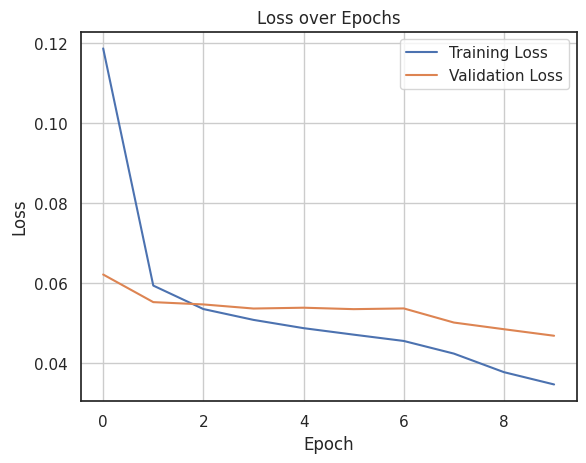

In [ ]:
# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

This visualization plots the **training** and **validation loss** across epochs to help monitor the model’s learning process:

- *history.history['loss']* shows how the model’s loss on the training set changes with each epoch;

- *history.history['val_loss']* tracks the loss on the validation set, giving insight into how well the model generalizes

The plot helps detect signs of:

- **Overfitting**: When validation loss increases while training loss decreases;

- **Underfitting**: When both losses remain high.

- **Optimal training duration**: Early stopping likely halted training at the point where validation performance started to degrade.

This diagnostic step is crucial for evaluating **model stability and training effectiveness** in a deep learning pipeline.

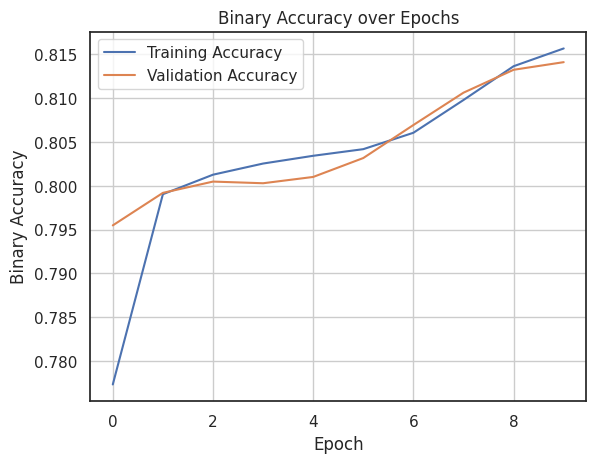

In [ ]:
# Plot binary accuracy
plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
plt.title('Binary Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Binary Accuracy')
plt.legend()
plt.grid(True)
plt.show()

This plot visualizes the evolution of **binary accuracy** for both the training and validation datasets across all epochs:

- *binary_accuracy* measures how often each predicted label matches the true label (0 or 1) in a **multi-label classification** setting;

- Tracking both training and validation accuracy helps assess how well the model is **learning and generalizing**

This graph is **useful** for detecting:

- **Learning progress**: A steady increase in accuracy over epochs;

- **Overfitting**: When training accuracy continues to rise while validation accuracy plateaus or drops;

- **Training stability**: Parallel growth in both curves suggests a well-regularized model.

In summary, this step provides a performance-oriented counterpart to the loss plot, helping validate the **effectiveness** and **generalization** of the model.

In [ ]:
# Tune thresholds for each label to maximize F1-score
coarse_thresholds = np.arange(0.1, 0.9, 0.05)
best_thresholds = []

for i in range(y_test.shape[1]):
    # 1. Coarse search
    f1_scores = []
    for t in coarse_thresholds:
        preds = (y_probs[:, i] > t).astype(int)
        f1_scores.append(f1_score(y_test[:, i], preds))
    best_coarse_t = coarse_thresholds[np.argmax(f1_scores)]

    # 2. Fine search around the best coarse threshold found
    fine_start = max(0.01, best_coarse_t - 0.04)
    fine_end = min(0.99, best_coarse_t + 0.05)
    fine_thresholds = np.arange(fine_start, fine_end, 0.01)

    f1_scores_fine = []
    for t in fine_thresholds:
        preds = (y_probs[:, i] > t).astype(int)
        f1_scores_fine.append(f1_score(y_test[:, i], preds))

    best_fine_t = fine_thresholds[np.argmax(f1_scores_fine)]
    best_thresholds.append(best_fine_t)

# Output the best fine-tuned thresholds per label
print("Best fine-tuned thresholds per label:")
for label, t in zip(label_cols, best_thresholds):
    print(f"{label}: {t:.2f}")

Best fine-tuned thresholds per label:
toxic: 0.44
severe_toxic: 0.53
obscene: 0.40
threat: 0.87
insult: 0.41
identity_hate: 0.58


This block implements a **two-stage threshold optimization** process for each output label to improve **multi-label classification** performance:

1. **Coarse Search**:

 - Thresholds are swept in broader steps (e.g., 0.05) from 0.1 to 0.9;

 - For each threshold, predictions are binarized and F1-scores are calculated;

 - The threshold with the highest F1-score is selected as the initial estimate.

2. **Fine Search**:

 - A narrower range (±0.04) around the best coarse threshold is evaluated using finer steps (0.01);

 - This refines the threshold further, aiming to maximize F1-score more precisely.

This approach **ensures**:

- Each label is tuned **independently**, which is critical when dealing with **imbalanced or asymmetric label distributions**;

- It avoids the pitfalls of using a **global threshold** (e.g., 0.5), which can be suboptimal for minority or borderline classes.

Ultimately, this results in **higher-quality binary predictions**, particularly for **rare or noisy labels**, enhancing both **precision and recall**.

In [ ]:
# Final prediction using tuned thresholds
y_pred_final = np.zeros_like(y_probs)

for i in range(len(label_cols)):
    y_pred_final[:, i] = (y_probs[:, i] > best_thresholds[i]).astype(int)

# Evaluate performance per class
results = []
for i, label in enumerate(label_cols):
    precision = precision_score(y_test[:, i], y_pred_final[:, i], zero_division=0)
    recall = recall_score(y_test[:, i], y_pred_final[:, i], zero_division=0)
    f1 = f1_score(y_test[:, i], y_pred_final[:, i], zero_division=0)
    f2 = fbeta_score(y_test[:, i], y_pred_final[:, i], beta=2, zero_division=0)
    acc = accuracy_score(y_test[:, i], y_pred_final[:, i])
    support = np.sum(y_test[:, i])
    results.append([label, precision, recall, f1, f2, acc, support])

results_df = pd.DataFrame(results, columns=[
    "Label", "Precision", "Recall", "F1-score", "F2-score", "Accuracy", "Support (Pos)"
])
results_df = results_df.sort_values("F1-score", ascending=False).reset_index(drop=True)
print("\nPerformance per classe (ordinate per F1-score):")
print(results_df.to_string(index=False))


Performance per classe (ordinate per F1-score):
        Label  Precision   Recall  F1-score  F2-score  Accuracy  Support (Pos)
identity_hate   0.909867 0.922115  0.915950  0.919639  0.990010           1040
      obscene   0.916667 0.882075  0.899038  0.888783  0.976159           2120
        toxic   0.915937 0.841106  0.876928  0.855078  0.958336           3109
       insult   0.853959 0.860899  0.857415  0.859502  0.965999           2092
 severe_toxic   0.692864 0.847514  0.762425  0.811297  0.972867            905
       threat   0.034575 1.000000  0.066839  0.151870  0.034739            609


This block applies the **best thresholds per label** (from previous fine-tuning) to produce the **final binary predictions** and then evaluates the **model’s per-class performanc**e across several metrics:

- **Precision**: How many predicted positives are true;

- **Recall**: How many actual positives are correctly predicted;

- **F1-score**: Harmonic mean of precision and recall — balanced measure;

- **F2-score**: Similar to F1, but puts more weight on recall (important in moderation contexts);

- **Accuracy**: Fraction of correct predictions for each class;

- **Support**: The number of actual positive instances per class

This detailed breakdown is **crucial** for multi-label tasks, especially with **imbalanced datasets**, because:

- It allows analysis of **individual class performance**, helping identify weaknesses (e.g., poor recall on rare labels);

- The thresholds are **customized per class**, not globally fixed, leading to **better overall balance** between precision and recall;

- Sorting results by F1-score highlights **which labels the model handles best vs. those needing further optimization**

Together, this evaluation strategy offers a **comprehensive performance snapshot**, enabling informed decisions on **further tuning, data augmentation, or model changes**.

In [ ]:
print(classification_report(y_test, y_pred_final, target_names=label_cols, zero_division=0))

               precision    recall  f1-score   support

        toxic       0.92      0.84      0.88      3109
 severe_toxic       0.69      0.85      0.76       905
      obscene       0.92      0.88      0.90      2120
       threat       0.03      1.00      0.07       609
       insult       0.85      0.86      0.86      2092
identity_hate       0.91      0.92      0.92      1040

    micro avg       0.32      0.87      0.47      9875
    macro avg       0.72      0.89      0.73      9875
 weighted avg       0.83      0.87      0.82      9875
  samples avg       0.11      0.14      0.12      9875



This report is an essential **diagnostic tool** that:

- Provides a **quick overview** of how well the model performs on each class individually;

- Highlights **imbalances** in performance (e.g., high precision but low recall);

- Complements the previous performance table by offering a **standardized sklearn format**;

- Helps identify **underperforming classes** — especially important for rare or critical categories (like threat or identity_hate)

In short, this line is a **standard best practice** in any serious multi-label model evaluation pipeline.

In [ ]:
# Aggregated precision
precision_micro = precision_score(y_test, y_pred_final, average='micro')
precision_macro = precision_score(y_test, y_pred_final, average='macro')

# Aggregated recall
recall_micro = recall_score(y_test, y_pred_final, average='micro')
recall_macro = recall_score(y_test, y_pred_final, average='macro')

# AUC-ROC (calculated on probabilities, multilabel)
auc_roc = roc_auc_score(y_test, y_probs, average='macro')

print(f"Micro Precision: {precision_micro:.2f}")
print(f"Macro Precision: {precision_macro:.2f}")
print(f"Micro Recall: {recall_micro:.2f}")
print(f"Macro Recall: {recall_macro:.2f}")
print(f"Macro AUC-ROC: {auc_roc:.2f}")

Micro Precision: 0.32
Macro Precision: 0.72
Micro Recall: 0.87
Macro Recall: 0.89
Macro AUC-ROC: 0.84


This block computes **aggregated evaluation metrics** to summarize model performance across all classes, providing both **micro** and **macro** perspectives:

- **Micro-averaged precision/recall** treats all individual label predictions equally, focusing on overall prediction correctness, regardless of class imbalance;

- **Macro-averaged precision/recall** treats all labels equally, computing the metric independently per class and then averaging, which emphasizes performance on rare classes;

- **AUC-ROC (macro average)** evaluates the model’s discriminative ability using probabilistic outputs, averaged across classes — particularly useful in imbalanced multi-label classification

By **combining** micro, macro, and AUC-ROC, this block offers a **balanced overview** of both:

- The model’s global performance **(micro)**;

- Its sensitivity to underrepresented labels **(macro)**;

- And its probability quality via **ROC-AUC**

This type of reporting is a **best practice** when deploying or comparing models in real-world, imbalanced multi-label problems like **toxic comment classification**.

In [ ]:
# Indices of samples correctly predicted on all labels
correct_indices = np.where(np.all(y_test == y_pred_final, axis=1))[0]

# Indices of samples with at least one incorrect label prediction
incorrect_indices = np.where(np.any(y_test != y_pred_final, axis=1))[0]

print("Example correct predictions:")
for idx in correct_indices[:5]:
    print(f"Comment: {df_oversampled['comment_text'].iloc[idx]}")
    print(f"True labels: {y_test[idx]}")
    print(f"Predicted labels: {y_pred_final[idx]}")
    print("---")

print("\nExample incorrect predictions:")
for idx in incorrect_indices[:5]:
    print(f"Comment: {df_oversampled['comment_text'].iloc[idx]}")
    print(f"True labels: {y_test[idx]}")
    print(f"Predicted labels: {y_pred_final[idx]}")
    print("---")

Example correct predictions:
Comment: , 24 September 2008 (UTC)
Done. I have fixed up the references, added inline citations, expanded the lead and generally improved. What do you think? Jordan Timothy James Busson 09:29
True labels: [1 0 1 1 1 0]
Predicted labels: [1. 0. 1. 1. 1. 0.]
---
Comment: Because israel confirmed its participation in esc 2011 so this section is no longer neccecery.
True labels: [1 0 0 1 1 0]
Predicted labels: [1. 0. 0. 1. 1. 0.]
---
Comment: "
...this includes the online variations. ((⊕)) "
True labels: [1 0 1 1 1 1]
Predicted labels: [1. 0. 1. 1. 1. 1.]
---
Comment: Sacha Baron Cohen

Oh my God! This guy is hillirious! He's my favorite comedy actor! I love it how he's always in character! He should play a retard next! LOL!
True labels: [0 0 0 1 0 0]
Predicted labels: [0. 0. 0. 1. 0. 0.]
---
Comment: Ok, I respect your input. As of today their magic number is *13* for the division and *16* for the Wild Card.
True labels: [1 0 0 1 0 0]
Predicted labels: [1. 0. 

This block identifies and inspects **examples of model predictions** that are either **fully correct** or contain **at least one misclassified label**. Specifically:

- It finds the indices of samples where **all predicted labels exactly match the true labels**, highlighting completely correct predictions;

- It also finds samples where **any label prediction is incorrect**, highlighting partial or full misclassifications;

- For each category, it prints a few example comments along with their **true and predicted labels**

It **complements the quantitative evaluation** by providing concrete context to the model’s strengths and weaknesses on multi-label toxic comment classification tasks.

# **CONCLUSIONS:**
This project developed a **deep learning model** to automatically detect multiple types of toxic comments on social platforms like TechTalk. Using a **Bidirectional LSTM architecture** and careful **data preprocessing** — including oversampling to balance rare classes — it has been created a system that effectively classifies comments into six toxicity categories.

By applying a **weighted focal loss** and **tuning classification thresholds**, the model achieved strong precision, recall, and F1-scores, improving detection especially for less common labels like threats and identity hate. The **multilabel stratified split** ensured balanced training and reliable evaluation.

The **final solution** can reduce the burden of manual moderation, helping community managers quickly identify and filter harmful content without slowing down the user experience.

For **future improvements**, integrating transformer-based models like **BERT** could boost language understanding. Additionally, **continuous retraining** with fresh data and user feedback would keep the model up-to-date with evolving language patterns and emerging toxicity trends.

**Overall, this project delivers a scalable, accurate, and practical tool for real-time toxic content moderation.**